# Video Frame Interpolation and Motion Compression

## Introduction
This Python 3 notebook is used to develop deep neural network architectures that facilitate video compression at a standard comparable or superior to common hand tuned video codecs such as H.264. All DNN Architectures are developed using the Pytorch 1.0.1 framework. 

**Requirements:**
   - Pytorch 1.0.1
   - Torchvision
   - NVVL
   - ScikitVideo
   - ScikitImage
   - OpenCV
   - Pyplot
   - PIL
   
**Kush Gauge:** W x H x F x M x 0.07 where M = {1, 2, 4}

**Imports**

In [1]:
import os
import torch
import decimal
import subprocess as sub
from video_codec import EvalMVC
import utils.curves as curve_t
from evaluate import EvalVideoModel
from process_data import VideoDataLoaders
from image_networks import ImageVAE
from video_networks import VideoAuto, PFrameVideoAuto, BFrameVideoAuto, VideoVAE

**Helper Functions**

In [2]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of output
    print(proc.stdout.read()) 
    return

"""
Function : float_to_str
    
    converts float to string without using scientific notation

"""

def float_to_str(f):
    ctx = decimal.Context()
    ctx.prec = 20
    d1 = ctx.create_decimal(repr(f))
    return format(d1, 'f')

## Data & Preprocessing

The Hollywood Dataset is used for training, validation and test data during model development.

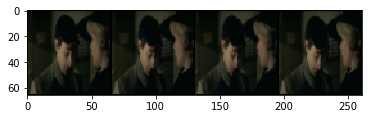

In [3]:
# create video dataLoaders
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=4, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space = 'RGB'
)
# display frames
vdls.display_gop('valid', widget=False)

## Video Inter-Frame Prediction Networks

<img src="files/model_diag/vid_net.png">

### Video Autoencoder (0.015625 bpp)
3D Convolutional Autonecoder that encodes video frames to a lower dimension discrete latent space (using STE binarisation) from which it aims to reconstruct the original video sequence.

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'VideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/VideoAuto',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/VideoAuto',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '16',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**DataLoader**

In [3]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=16, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation:**

In [4]:
# def Video Autoencoder
video_auto = VideoAuto(
    bnd=8
)

# load model weights
video_auto.load_model("./saved_models/VideoAuto/VideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 27.558929443359375
SSIM : 0.7256535887718201
VMAF : 57.314028
EPE  : 0.19836054742336273


**Average Stats**

In [5]:
# display average stats
ev.disp_avg_stats("valid")

PSNR : 23.712152624130248
SSIM : 0.641178548336029
VMAF : 41.210275125
EPE  : 0.49267157912254333


### P-Frame Video Auto (0.015625 bpp)

<img src="files/model_diag/pf_auto.png">

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'PFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/PFrameVideoAuto/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/PFrameVideoAuto/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '17',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**DataLoader**

In [3]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(640, 640), 
    n_gop=17, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [4]:
# def Video Autoencoder
pf_video_auto = PFrameVideoAuto(
    bnd=8
)

# load model weights
pf_video_auto.load_model("./saved_models/PFrameVideoAuto/8bnd/PFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(pf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 30.920215606689453
SSIM : 0.7775448560714722
VMAF : 45.66128
EPE  : 2.0123982429504395


**Average Stats**

In [14]:
# dosplay compression stats
ev.disp_avg_stats('valid')

PSNR : 28.25001277923584
SSIM : 0.8026221990585327
VMAF : 62.311287000000014
EPE  : 0.47697994112968445


### B-Frame Video Auto (0.015625 bpp)

<img src="files/model_diag/bf_auto.png">

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**DataLoader**

In [5]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [6]:
# def Video Autoencoder
ms_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
ms_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(ms_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

PSNR : 28.60327911376953
SSIM : 0.7809532284736633
VMAF : 36.606187
EPE  : 0.7423205971717834


**Average Stats**

In [5]:
ev.disp_avg_stats('valid')

PSNR : 29.814650058746338
SSIM : 0.8423969149589539
VMAF : 71.03221519999997
EPE  : 0.4772859513759613


### Flow Loss Experiment

<img src="files/model_diag/flow_setup.png">

#### Multiscale B-Frame Video Auto (0.015625 bpp)  with EPE Flow Loss

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/FlowLoss/EPE/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/FlowLoss/EPE/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--multiscale'      ,
    '--epe_flow_loss'   ,
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**DataLoader**

In [2]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(224, 320), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [4]:
# def Video Autoencoder
epe_flow_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
epe_flow_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/FlowLoss/EPE/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(epe_flow_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

**Average Stats**

In [8]:
ev.disp_avg_stats("valid")

PSNR : 29.587791156768798
SSIM : 0.8361989855766296
VMAF : 70.18845787500001
EPE  : 0.4614894390106201


### B-Frame Video Auto (0.015625 bpp)  with Cosine Flow Loss

**Train Model**

In [ ]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/FlowLoss/Cosine/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/FlowLoss/Cosine/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--multiscale'      ,
    '--cos_flow_loss'   ,
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**DataLoader**

In [9]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [10]:
# def Video Autoencoder
cos_flow_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
cos_flow_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/FlowLoss/Cosine/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(cos_flow_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 25.356769561767578
SSIM : 0.6104382276535034
VMAF : 64.19858
EPE  : 0.2772670388221741


**Average Stats**

In [11]:
ev.disp_avg_stats("valid")

PSNR : 24.03662736415863
SSIM : 0.6516504883766174
VMAF : 59.43501727499999
EPE  : 0.5140184760093689


### 3D Dynamic Bit Assignment

<img src="files/model_diag/dba.png">

#### B-Frame Video Auto (0.015625 bpp) with Bit Importance Map and Bitrate Loss

#### L=2

**Train Models**

In [ ]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_2/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_2/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '2',
        '--verbose'             ,
        '--checkpoint'
    ]
    # run cmd
    run_cmd(cmd)


#### L=4

**Train Models**

In [ ]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_4/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_4/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '4',
        '--verbose'             ,
        '--checkpoint'
    ]
    
    # run cmd
    run_cmd(cmd)

#### L=8

**Train Models**

In [ ]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_8/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_8/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '8',
        '--verbose'             ,
        '--checkpoint'
    ]
    
    # run cmd
    run_cmd(cmd)

**Rate Loss Experiment**

**Compression Cruves produced by varying lamda and L terms**

/home/wintermute/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


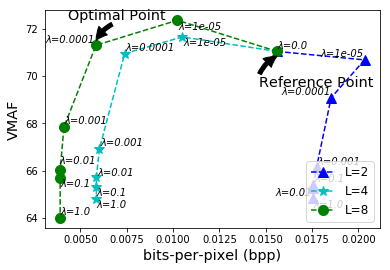

In [22]:
# rl lambda terms
rl_lambda = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

# plot curves
curve_t.BitrateLossCurves(
    [], None, rl_lambda, None
).plot_curve([
    "./saved_cc/rate_loss_exp/VMAF_2.npy",
    "./saved_cc/rate_loss_exp/VMAF_4.npy",
    "./saved_cc/rate_loss_exp/VMAF_8.npy"
])

**DataLoader**

In [2]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(320, 640), 
    n_gop=26, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Load Model**

In [3]:
# def Video Autoencoder
rl_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# fine tune bitrate
rl_bf_video_auto.fine_tune_bitrate(L=8)

# load model weights
rl_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/fine_tuned/BFrameVideoAuto.pt")
ev = EvalVideoModel(rl_bf_video_auto, vdls, standard_epe=False)

**Bit Heat Map Plot**

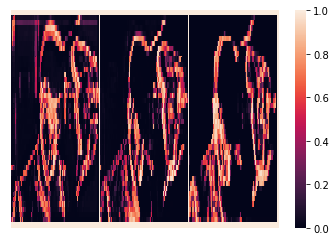

In [4]:
# display compressed vs reference frames
ev.disp_bit_heatmaps(dataset="valid")

# Standard Block Motion Estimation and Compensation

**Exhaustive Search (ES)**

In [5]:
from video_codec import EvalMVC

# evaluate Exhaustive Search (ES)
ev_es = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ES", 
    mb_size=16, 
    search_dist=7
)

ev_es.display_avg_stats()

Bpp  : 0.01084528962290027
PSNR : 16.348614987680467
SSIM : 0.8503439426422119
VMAF : 44.63794928389827
EPE  : 0.4508008360862732
Time (sec) : 11.348345615370278


**Three Step Search (TSS)**

In [7]:
from video_codec import EvalMVC

# evaluate Three Step Search (TSS)
ev_tss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="3SS", 
    mb_size=16, 
    search_dist=7
)

ev_tss.display_avg_stats()

Bpp  : 0.010805812586306373
PSNR : 16.371392884496917
SSIM : 0.8511433601379395
VMAF : 44.80819861864405
EPE  : 0.45839357376098633
Time (sec) : 1.532558727709545


**New Three Step Search (NTSS)**

In [6]:
from video_codec import EvalMVC

# evaluate New Three Step Search (NTSS)
ev_ntss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="N3SS", 
    mb_size=16, 
    search_dist=7
)

ev_ntss.display_avg_stats()

Bpp  : 0.010695465309567947
PSNR : 16.348336878469436
SSIM : 0.851489245891571
VMAF : 44.762505805084714
EPE  : 0.4500148892402649
Time (sec) : 1.1757741397299992


**Simple and Efficient Search (SES)**

In [5]:
from video_codec import EvalMVC

# evaluate Simple and Efficient Search (SES)
ev_ds = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="SE3SS", 
    mb_size=16, 
    search_dist=7
)

ev_ds.display_avg_stats()

Bpp  : 0.006787412334008015
PSNR : 15.79967544038417
SSIM : 0.8456442356109619
VMAF : 40.94133457203391
EPE  : 0.433091402053833
Time (sec) : 0.9633520170612166


**Four Step Search (FSS)**

In [4]:
from video_codec import EvalMVC

# evaluate Four Step Search (FSS)
ev_fss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="4SS", 
    mb_size=16, 
    search_dist=7
)

ev_fss.display_avg_stats()

Bpp  : 0.007709076444981458
PSNR : 16.29324743303202
SSIM : 0.8517541289329529
VMAF : 44.76818085593216
EPE  : 0.4734130799770355
Time (sec) : 1.0073124575399068


**Diamond Search (DS)**

In [3]:
from video_codec import EvalMVC

# evaluate Diamond Search (DS)
ev_ds = EvalMVC(
    video_dir="~/Videos/hollywood/test/", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="DS", 
    mb_size=16, 
    search_dist=7
)
ev_ds.display_avg_stats()

Bpp  : 0.010023701739368947
PSNR : 15.698714983665337
SSIM : 0.8159193992614746
VMAF : 37.89803281355932
EPE  : 0.5090603232383728
Time (sec) : 0.7696276196324013


**Adaptive Rood Pattern Search (ARPS)**

In [9]:
from video_codec import EvalMVC

# evaluate Adaptive Rood Pattern Search (ARPS)
ev_arp = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ARPS", 
    mb_size=16, 
    search_dist=7
)

ev_arp.display_avg_stats()

Bpp  : 0.00973914564377459
PSNR : 15.662746292049603
SSIM : 0.8155364394187927
VMAF : 37.89305063135592
EPE  : 0.49193283915519714
Time (sec) : 0.6321978793002002


In [2]:
from video_codec import EvalMVC
print("ESS ********************")
# evaluate Exhaustive Search (ES)
ev_es = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ES", 
    mb_size=8, 
    search_dist=7
)

ev_es.display_avg_stats()

ESS ********************
Bpp  : 0.05825606154471856
PSNR : 19.446509272365248
SSIM : 0.9006776809692383
VMAF : 62.973122279661006
EPE  : 0.4006761908531189
Time (sec) : 46.322017972739374


## Compression Curves

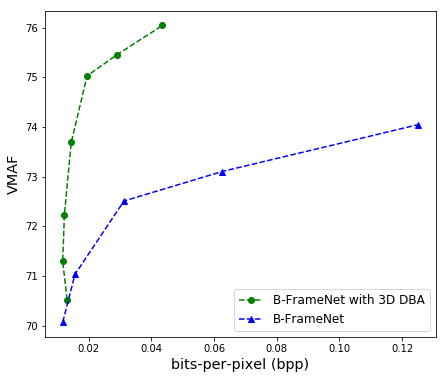

In [7]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/dba_exp/B-FrameNet with 3D DBA_VMAF.npy",
        "./saved_cc/dba_exp/B-FrameNet_VMAF.npy"
    ]
)
cc.disp_curves(save_fig=True)

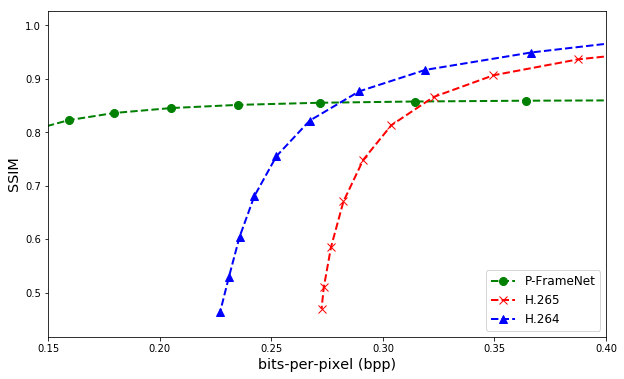

In [4]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/pf_64x64_vtl/P-FrameNet_SSIM.npy",
        "./saved_cc/pf_64x64_vtl/H.265_SSIM.npy",
        "./saved_cc/pf_64x64_vtl/H.264_SSIM.npy",
    ]
)
cc.disp_curves(save_fig=True)

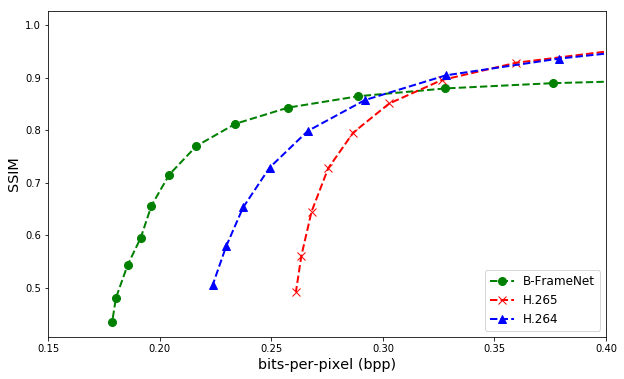

In [2]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/bf_64x64_vtl/B-FrameNet_SSIM.npy",
        "./saved_cc/bf_64x64_vtl/H.265_SSIM.npy",
        "./saved_cc/bf_64x64_vtl/H.264_SSIM.npy",
    ]
)
cc.disp_curves(save_fig=True)

**Load B-Frame Net**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


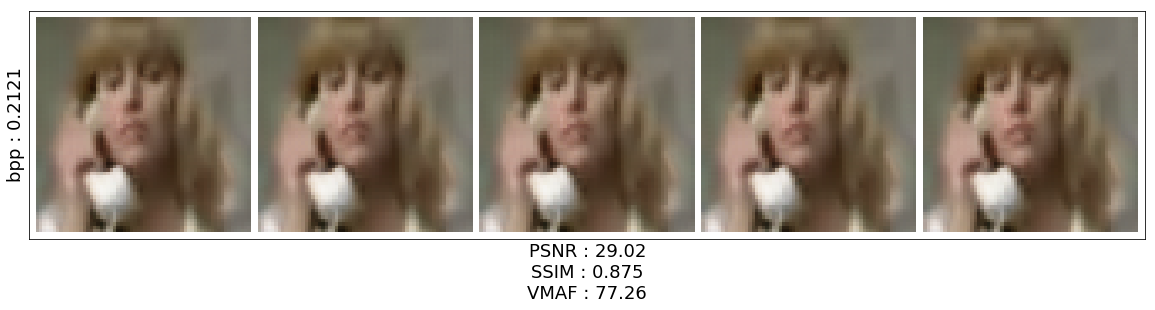

In [2]:
# 64 x 64 WILD & VTL
vdls = VideoDataLoaders(
    b_s=1,
    f_s=(64, 64),
    n_gop=18,
    nvvl=False,
    vid_ext='.mp4',
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)
bf_video_auto.fine_tune_bitrate(L=8)

# load model weights
bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/fine_tuned/BFrameVideoAuto.pt")
ev = EvalVideoModel(bf_video_auto, vdls, if_codec="libx264", standard_epe=False)

ev.disp_comp_frames(dataset="test", q=28, frames_start=8, frame_end=13)

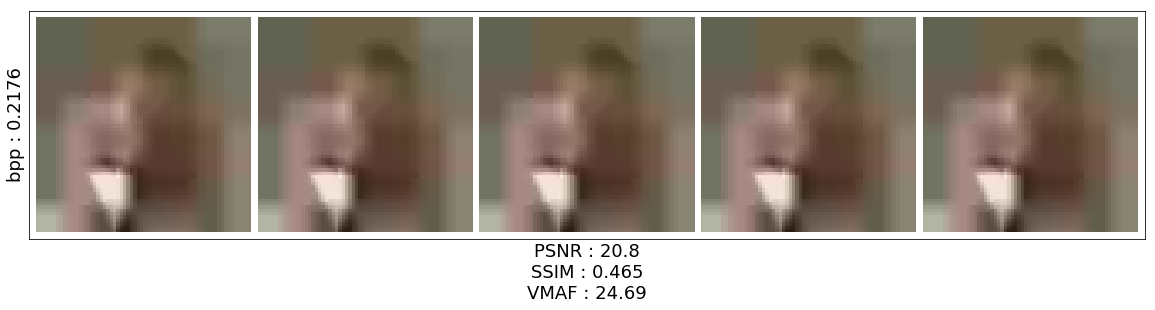

In [3]:
from video_codec import VideoCodec

codec = VideoCodec(
    codec="libx264", 
    n_gop=18, 
    f_s=(64,64), 
    root_dir="~/Videos/hollywood/test", 
    vid_ext='mp4'
)

codec.disp_comp_frames(q=52, fr_start=8, fr_end=13)

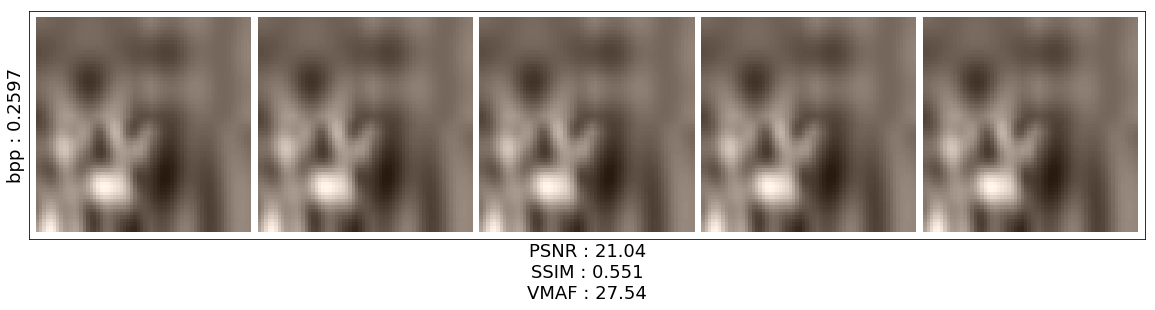

In [4]:
from video_codec import VideoCodec

codec = VideoCodec(
    codec="libx265", 
    n_gop=18, 
    f_s=(64,64), 
    root_dir="~/Videos/hollywood/test", 
    vid_ext='mp4'
)

codec.disp_comp_frames(q=51, fr_start=8, fr_end=13)